This script generates hillslope mesh with a varying organic layer thickness at the top.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import exodus3
import watershed_workflow.mesh

In [2]:
def create_skew_sigmoid_hillslope_multi(
    x_start, x_end, z_top, z_bottom,
    num_points, x0_frac=0.3, k=0.1,
    densify_ranges=None  # (start, end, factor)
):
    """
    Create a left-skewed sigmoid-shaped hillslope profile with optional multiple
    densification bands. Each band is (start, end, factor) where factor>=2
    means 'factor' times the base resolution inside that band.
    """
    # Base grid and spacing
    x_uniform = np.linspace(x_start, x_end, num_points)
    print(x_uniform)
    step = (x_end - x_start) / (num_points - 1)

    # Snap bands to the grid
    snapped_bands = []
    if densify_ranges is None:
        densify_ranges = []
    for s, e, f in densify_ranges:
        if f is None or f < 2:
            continue
        s_snap = x_start + round((s - x_start)/step) * step
        e_snap = x_start + round((e - x_start)/step) * step
        if e_snap <= s_snap:  # ignore empty/invalid
            continue
        # clamp to domain
        s_snap = max(s_snap, x_start)
        e_snap = min(e_snap, x_end)
        if e_snap > s_snap:
            snapped_bands.append((s_snap, e_snap, int(f)))

    # For each base interval [x_i, x_{i+1}] decide the local factor
    factors = np.zeros(len(x_uniform) - 1, dtype=int)
    if len(snapped_bands) > 0:
        # Use the interval midpoint to test inclusion in a band
        mids = 0.5 * (x_uniform[:-1] + x_uniform[1:])
        for s, e, f in snapped_bands:
            in_band = (mids >= s) & (mids <= e)
            factors[in_band] = np.maximum(factors[in_band], f)

    # Build the refined x by subdividing each base interval
    xs = []
    for i in range(len(x_uniform) - 1):
        left, right = x_uniform[i], x_uniform[i + 1]
        m = int(factors[i])  # subdivisions factor
        # Emit m sub-steps, excluding the right endpoint to avoid duplicates
        xs.append(np.linspace(left, right, m + 1, endpoint=False))
    xs.append(np.array([x_uniform[-1]]))  # finally add the last endpoint
    x_all = np.concatenate(xs)

    # Sigmoid z
    x0 = x_start + x0_frac * (x_end - x_start)
    z = z_bottom + (z_top - z_bottom) / (1 + np.exp(k * (x_all - x0)))

    return pd.DataFrame({"x": x_all, "z": z})

In [3]:
def create_skew_sigmoid_hillslope(x_start, x_end, z_top, z_bottom, 
                                   num_points, x0_frac=0.3, k=0.1):
    """
    Create a left-skewed sigmoid-shaped hillslope profile.
    """
    x0 = x_start + x0_frac * (x_end - x_start)
    x = np.linspace(x_start, x_end, num_points)
    print(x)
    z = z_bottom + (z_top - z_bottom) / (1 + np.exp(k * (x - x0)))
    return pd.DataFrame({"x": x, "z": z})

In [4]:
def elliptical_lake_profile(x, lake_left=40, lake_right=60, max_depth=4.0):
    """
    Create a 1D plain (z=0) with an elliptical-arc lake between lake_left and lake_right.
    The lake is a half-ellipse with maximum depth 'max_depth' at the midpoint.

    Parameters
    ----------
    x_start, x_end : float
        Domain limits for x.
    num_points : int
        Number of samples across the domain.
    lake_left, lake_right : float
        Horizontal extents of the lake (shoreline where z returns to 0).
    max_depth : float
        Maximum depth (positive number) at the lake center.

    Returns
    -------
    pandas.DataFrame with columns ['x','z']
    """
    if lake_right <= lake_left:
        raise ValueError("lake_right must be greater than lake_left.")
    if max_depth < 0:
        raise ValueError("max_depth must be positive.")

    a = 0.5 * (lake_right - lake_left)   # horizontal semi-axis
    b = float(max_depth)                 # vertical semi-axis (depth)
    x0 = 0.5 * (lake_left + lake_right)  # center    
    z = np.zeros_like(x, dtype=float)
    mask = (x >= lake_left) & (x <= lake_right)
    # z(x) for the lower half of an ellipse centered at z=0
    under = 1.0 - ((x[mask] - x0) / a) ** 2
    under = np.clip(under, 0.0, None)  # numerical safety at the endpoints
    z[mask] = -b * np.sqrt(under)

    return pd.DataFrame({"x": x, "z": z})

In [12]:
# create the basic profile
df_skew = create_skew_sigmoid_hillslope_multi(
    x_start=0, x_end=500, z_top=20, z_bottom=0, num_points=101, x0_frac=0.3, k=0.015,
    )

# create the profile of the ellipse
df_ellipse = elliptical_lake_profile(
    df_skew.x, lake_left=300, lake_right=400, max_depth=2
    )

# create the profile of the top-of-bedrock
df_bottom = create_skew_sigmoid_hillslope_multi(
    x_start=0, x_end=500, z_top=0, z_bottom=-10, num_points=101, x0_frac=0.3, k=0.015,
    )

x = df_skew.x
z_surf = (df_skew.z + df_ellipse.z).to_numpy()
z_topsoil = (df_skew.z - 1.2).to_numpy()
z_bot = df_bottom.z.to_numpy()


[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495. 500.]
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475.

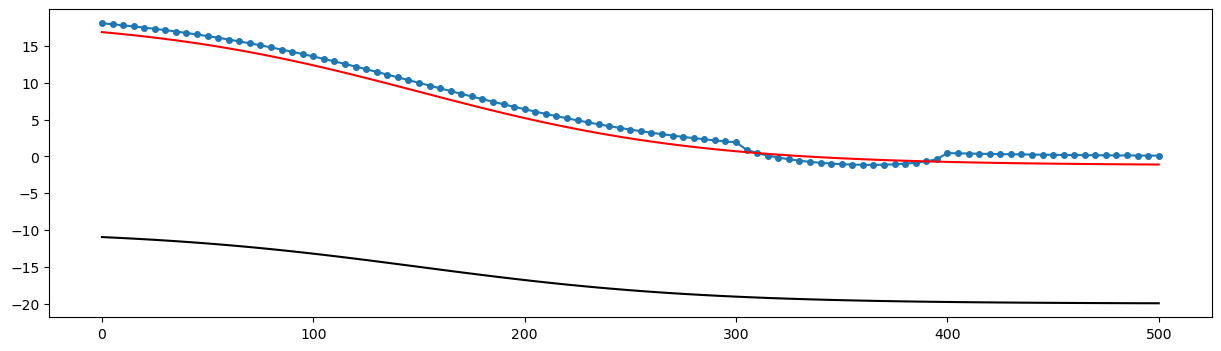

In [13]:
# plot the basic profile
fig,ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(x, z_surf, '-o', ms=4)
ax.plot(x, z_topsoil, 'r')
ax.plot(x, z_bot - 10, 'k')


In [14]:
m2 = watershed_workflow.mesh.Mesh2D.from_Transect(x, z_surf)
print(f'Creating m2 mesh with {len(m2.conn)} elements.')

Creating m2 mesh with 100 elements.


In [15]:
# Surface regions :
hillslope = 0, 300 # start and end, [m]
lake = 300, 400
toeslope = 400, 500
golf_course = 100, 200
forested1 = (0, 100)
forested2 = 200, 300

def getCells(start, end):
    return np.where(np.bitwise_and(m2.centroids[:,0] > start,
                                   m2.centroids[:,0] < end))[0]

def addLabeledSet(label, label_id, bounds):
    if isinstance(bounds, tuple):
        bounds = [bounds,]

    cells = [c for b in bounds for c in getCells(*b)]
    ls = watershed_workflow.mesh.LabeledSet(label, label_id, 'CELL', cells, to_extrude=False)
    m2.labeled_sets.append(ls)
    return ls

addLabeledSet('hillslope', 11, hillslope)
addLabeledSet('lake', 12, lake)
addLabeledSet('toeslope', 13, toeslope)
addLabeledSet('golf course', 14, golf_course)
addLabeledSet('forested', 15, [forested1, forested2])

for ls in m2.labeled_sets:
    print(ls.name, ls.setid, ls.entity, len(ls.ent_ids))


hillslope 11 CELL 60
lake 12 CELL 20
toeslope 13 CELL 20
golf course 14 CELL 20
forested 15 CELL 40


In [ ]:
dzs = [ [0.05,]*4, [0.1,]*4, [0.2,]*3, [0.4,]*2, [1., 1., 2., 4,] ]
dzs = [i for j in dzs for i in j]
nz = len(dzs)
print(f'Extruding:  number of cells = {nz} to total depth of {sum(dzs)}')

# layer extrusion
# -- data structures needed for extrusion
layer_types = ['vertex',] * nz
layer_ncells = [1,] * nz

# squish the vertical under the lake
squish_factor = (z_surf - z_bot) / sum(dzs)
o1 = np.outer(np.array([1,1]), squish_factor)

layer_data = np.outer(np.array(dzs), o1)
print(layer_data.shape)
print(layer_data.sum(0))

# 11 layers --> topsoil 1.2m
cumulative_dzs = np.cumsum(dzs)
layer_mat_ids = np.where(cumulative_dzs < 1.2, 101, 102)

# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, list(layer_data), layer_ncells, layer_mat_ids)


Extruding:  number of cells = 17 to total depth of 10.0
(17, 202)
[19.04650535 18.97981931 18.90903179 18.83397031 18.75446642 18.6703576
 18.58148935 18.48771747 18.3889105  18.2849523  18.17574476 18.06121062
 17.94129628 17.81597464 17.68524783 17.54914987 17.40774899 17.26114981
 17.10949503 16.95296669 16.79178699 16.62621837 16.45656306 16.28316188
 16.10639234 15.926666   15.74442517 15.56013891 15.37429845 15.18741216
 15.         14.81258784 14.62570155 14.43986109 14.25557483 14.073334
 13.89360766 13.71683812 13.54343694 13.37378163 13.20821301 13.04703331
 12.89050497 12.73885019 12.59225101 12.45085013 12.31475217 12.18402536
 12.05870372 11.93878938 11.82425524 11.7150477  11.6110895  11.51228253
 11.41851065 11.3296424  11.24553358 11.16602969 11.09096821 11.02018069
 10.95349465 10.01895549  9.63172696  9.34800894  9.12426485  8.9434161
  8.79670328  8.67902335  8.58722138  8.51933983  8.47425873  8.45152853
  8.45132099  8.47447851  8.52268161  8.59880898  8.70768859  

In [ ]:
# Save mesh 
filename = '../data/hillslope_mesh.exo'
if os.path.exists(filename):
    os.remove(filename)
m3.writeExodus(filename)

Opening exodus file: ../data/hillslope_mesh.exo
Closing exodus file: ../data/hillslope_mesh.exo
